# Programming Assignment 6 (PA6): Inverse Kinematics

### CS70 — Foundations of Applied Computer Science
---

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text (using Markdown). Please complete/extend this notebook for your homework submission:

* For any mathematical questions, make sure to **show you work**.
* For any questions that ask for code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use [Anaconda](https://www.anaconda.com/products/individual), specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS70 count towards your final grade and must therefore be done individually.
</div>

$$
\newcommand{\vp}{\mathbf{p}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\mA}{\mathbf{A}}
$$

## Import statements

We provide the import statements required to complete the assignment in the following cell. 

<div class="alert alert-danger" role="alert">
    <b>Import policy:</b> You must not use any <code>import</code>'s other than the ones we provide.
</div>

In this assignment, we will make use a library called **[bqplot](https://github.com/bloomberg/bqplot)** developed by Bloomberg, which enables fully interactive plots within the Jupyter notebook. By default, this library is not part of the Anaconda Python distribution, but the CS70 environment we provided should have installed it for you.

If bqplot was installed correctly, the commands in the following cell should display a figure with a pie chart.

In [20]:
import bqplot as bqp
bqp.Figure(marks=[bqp.Pie(sizes=range(1, 6))], title='A pie chart!')

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, marks=[Pie(colors=['#1f77b4', '#ff7f0e',…

If you received an error related to bqplot above, walk through the instructions below to install that package. Afterwards, you will have to **restart** Jupyter notebook for the change to become effective, and then try to run the notebook from the top again.

### Installing additional prerequisites

To install bqplot, open the console (``cmd.exe`` on Windows or the standard terminal on Linux or MacOS) and enter the following commands.

```
pip install bqplot
jupyter nbextension enable --py --sys-prefix bqplot
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

**However**, note that some systems like MacOS ship a with default version of Python that is very old and outdated. To ensure that the right versions of the ``pip`` and ``jupyter`` commands are executed, it's safer to first navigate to the directory where Anaconda was installed and then execute the commands there. The following screenshots show how to do this on the various supported platforms (note the ``./`` prefix on Linux and Mac OS).

![bqplot.jpg](attachment:bqplot.jpg)

In [21]:
import numpy as np
import scipy.linalg as la

# New: Optimization package
import scipy.optimize as opt

# bqplot plotting library
import bqplot as bqp

# Import graphical user interface components used below
from ipywidgets import interact
from ipywidgets import FloatSlider, VBox


## Part 1: Forward Kinematics

In this exercise, we'll investigate the mathematics of a very simple kind of "skeleton": a chain of bones in two dimensions with joint positions $\vp_i = (x_i, y_i)$. The first joint is rigidly attached to the origin (i.e. $\vp_0 = (0, 0)$) while the other joints and bones are free to move in any way. For simplicitly, we'll also assume that all of the bones have the same length $l_1=l_2=\ldots=1$.

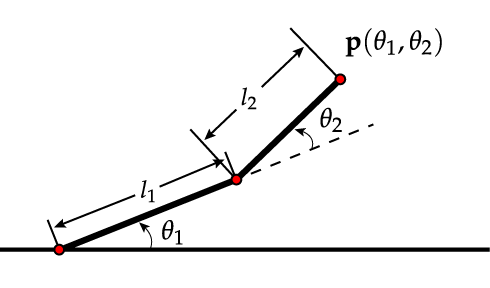

Each parameter $\theta_i\in[0,2\pi]$ specifies the counter-clockwise angle that the associated bone from joint $\vp_{i-1}$ to joint $\vp_i$ makes with its predecessor bone (the pair of bones are parallel if $\theta_i=0$). The first bone doesn't have a predecessor, hence $\theta_1$ is measured relative to the $X$ axis. Note how the complete set of bone angles $\theta_1, \theta_2, \ldots$ is all the information we need to compute the precise positions of all the joint positions in Euclidean space.

Forward kinematics (FK) is defined as the problem of converting a set of bone angles $\theta_i$ into joint positions $\vp_i$. Since $\vp_i$ depends on all of the preceding angles, we can think of each joint position as a function $\vp_i=\vp(\theta_1,\ldots,\theta_{i})$ 

## 1.1 A simple 1-segment chain

<div class="alert alert-info" role="alert">

**TODO:** Your first task is to create a function `chain_simple`, which solves the forward kinematics for a chain with at most one bone. The function should take an array of angles as a parameter, which can be of length 0 or 1 (use the Python `len()` function to query the length of an array). When no angles are specified, the function should return the position of the first joint $(x_0,y_0)=(0, 0)$ as a 1D NumPy array. When a single angle is specified, it should return the position $x_1, y_1$.

Ensure that your implementation returns the expected example values in the cell below (up to minor rounding errors).
</div>

In [42]:
# TODO
def chain_simple(theta):

    p1 = np.array([0.,0.])
    length = len(theta)
    
    if length == 0:
        # Return 0 array if theta is empty
        return p1
    elif length == 1:
        arr = np.array([1., 0.])
        rotate = np.array([[np.cos(theta[0]), -np.sin(theta[0])],
                          [np.sin(theta[0]), np.cos(theta[0])]])
        return rotate@arr + p1

# TESTS (Do not modify!)
print('chain_simple:', chain_simple([]))
print('reference:   ', np.array([0.,0.]))
print()
print('chain_simple:', chain_simple([0.]))
print('reference:   ', np.array([1., 0.]))
print()
print('chain_simple:', chain_simple([np.pi / 4]))
print('reference:   ', np.array([ 0.70710678,  0.70710678]))


chain_simple: [0. 0.]
reference:    [0. 0.]

chain_simple: [1. 0.]
reference:    [1. 0.]

chain_simple: [0.70710678 0.70710678]
reference:    [0.70710678 0.70710678]


## 1.2 Visualization of the forward kinematics

### Helper function

We provide the function ``fk_demo()`` below to interactively explore the possible chain configurations via forward kinematics. The implementation uses the ``bqplot`` library mentioned above and is fairly technical. You are welcomed but not expected to read or understand how it works.

In [43]:
def fk_demo(chain_func, theta, extra = [[],[]]):
    '''
    This function visualizes the configuration of a chain of bones
    and permits interactive changes to its state. It expects two arguments:
    
    ``chain_func``: a function that implements forward kinematics by
    turning a sequence of angles (theta_1, theta_2, ..., theta_n) into
    the position of the last joint of this chain (x_n, y_n).
    
    ``theta``: an array with the initial angles of all joints
    
    ``extra``: An optional argument which can be used to plot
    additional points that are highlighted in red
    '''
    
    # Function which repeatedly calls ``chain_func`` to compute all joint positions
    def chain_all(theta):
        return np.column_stack([chain_func(theta[:i]) for i in range(0, len(theta) + 1)])

    # Determine size and initial configuration
    size = len(theta)
    positions = chain_all(theta)

    # Define the range of the plotting frame
    scales = { 'x': bqp.LinearScale(min=-size-1, max=size+1),
               'y': bqp.LinearScale(min=-size-1, max=size+1) }

    # Create a scatter plot (for joints), a line plot (for bones), and
    # another scatter plot (to draw extra points specified the ``extra`` argument)
    scat  = bqp.Scatter(scales=scales)
    lines = bqp.Lines(scales=scales)
    scat2 = bqp.Scatter(scales=scales, colors=['red'])

    # Create a figure that combines the three plots
    figure = bqp.Figure(marks=[scat, scat2, lines])
    figure.layout.height = '500px'
    figure.layout.width = '500px'

    # Initialize the plots with the initial data
    scat.x, scat.y = positions
    lines.x, lines.y = positions
    scat2.x, scat2.y = extra
    
    sliders = []
    
    # For each angle theta_i,
    for i in range(len(theta)):
        # Create a graphical slider
        slider = FloatSlider(min=0, max=2*np.pi, value=theta[i], step=1e-3)
        
        # Define a callback function that will be triggered when the slider is moved
        def callback(value, i = i):
            theta[i] = value['new']
            positions = chain_all(theta)
            scat.x, scat.y = positions
            lines.x, lines.y = positions

        # "Attach" the callback function to the slider
        slider.observe(callback, 'value')
        sliders.append(slider)

    # Combine the plots and sliders in a vertical arrangement
    return VBox([*sliders, figure])

<div class="alert alert-info" role="alert">

**TODO:** To ensure that your implementation of `chain_simple` satisfies all the specifications, invoke the `fk_demo()` function with arguments `chain_simple` and ``[0.]`` (the initial parameters of a flat chain). You should be able to drag a slider from 0 to $2\pi$ and see a visual representation of a 1-bone chain turning counter-clockwise.
</div>

In [44]:
# TODO
fk_demo(chain_simple, [0.])


## 1.3 Longer chains

<div class="alert alert-info" role="alert">

**TODO:** Create a function `chain`, which solves the forward kinematics for an arbitrarily long sequence of bones. The function should take an arbitrary-length array of angles as a parameter. When no angles are specified, the function should return the position $(x_0, y_0)$ as before. When $i$ angles are specified, it should (only) return  the joint position $(x_{i}, y_{i})$. You'll likely want to use recursion, which allows for a particularly simple implementation.

Ensure that your implementation returns the expected example values in the cell below (up to minor rounding errors).
</div>

In [45]:
# TODO
def chain(theta):
    
   # Base case: no angles left, return the origin
    if len(theta) == 0:
        return chain_simple(theta)  # Use np.array for consistency
    
    else:
        # Extract the first angle from the list
        angle = theta[0]
        
        # Remove the first angle from the list (use slicing)
        theta_new = theta[1:]
        
        # Calculate the position for the first angle
        position = chain_simple([angle])
        
        # Define the transformation matrix for the current angle
        base = np.array([[position[0], -position[1]],
                         [position[1], position[0]]])
        
        return position + base@chain(theta_new)
# TESTS (Do not modify!)
print('chain:     ', chain([0.1, 0.2, 0.3, 0.4]))
print('reference: ', np.array([ 3.31597858,  1.80146708]))
print()
print('chain:     ', chain([np.pi, np.pi, np.pi, np.pi]))
print('reference: ', np.array([0, 0]))


chain:      [3.31597858 1.80146708]
reference:  [3.31597858 1.80146708]

chain:      [ 0.0000000e+00 -2.4492936e-16]
reference:  [0 0]


## 1.4 Attempting to reach a certain position

Uncomment the command `fk_demo(chain, [0, 0, 0, 0, 0], [[-2], [3]])` in the cell below. You should see a chain with five segments and five corresponding sliders, as well as an additional point highlighted in red.

<div class="alert alert-info" role="alert">

**TODO:** Find a configuration of angles that brings the endpoint of the chain as close as possible to the highlighted location `[-2, 3]]`. An exact match is not necessary, but the points should overlap by a significant margin. Before you finish, make sure to copy the parameters you found into the argment list of the `fk_demo` function call so it shows up automatically for us when grading.

</div>

In [47]:
# TODO:
fk_demo(chain, [0, 0, 0, 0, 0], [[-2], [3]])
fk_demo(chain, [.80, 0.92, .80, 6.22, .59], [[-2], [3]])


# Part 2: Inverse Kinematics

Problems similar to the one in Section 1.4 are tedious to solve by hand: all of the parameters are interdependent and must be adjusted in a coordinated manner. So-called *inverse kinematics* techniques apply numerical root finding to determine solutions to this problem in an automated way. Most modern animation systems have builtin support for inverse kinematics since it allows for a much more convenient workflow: rather than having to tweak each individual bone, artists can directly specify a target shape, and the system will automatically infer all the necessary rotations.

In this part of the exercise, we will use inverse kinematics to automatically determine $\theta_1,\ldots,\theta_n$ such that

$$
\vp(\theta_1,\ldots,\theta_n) = \vp_{\mathrm{target}}
$$

for a given value $\vp_{\mathrm{target}}\in\mathbb{R}^2$. In other words: the user can move around the endpoint of the chain, and the skeleton will automatically reconfigure itself to follow. This is illustrated in the following figure:

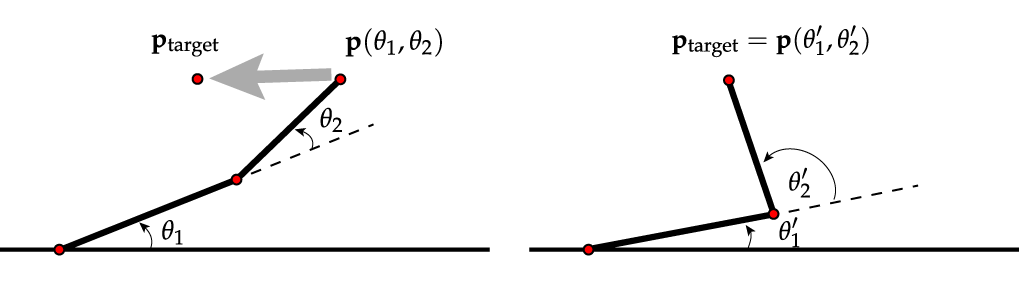

All good numerical root finding techniques require the ability to evaluate the Jacobian of $\vp$, i.e. all the partial derivatives $\frac{\partial\vp(\theta_1,\ldots,\theta_n)}{\partial \theta_j}$. The partial derivatives encode how a small perturbation of each of the angles $\theta_j$ leads to a corresponding change in $\vp(\theta_1,\ldots,\theta_n)$.

## 2.1 A simple 1-segment chain

As before, we'll first look at a 1-segment chain and then derive a solution for the general problem.
 
<div class="alert alert-info" role="alert">

**TODO:** Implement a function `dchain_simple(theta)` which takes an array with one entry, and which computes the function $\frac{\partial \vp(\theta_1)}{\partial \theta_1}$. The return value should be a two-dimensional array with one column and two rows containing the partial derivatives of the coordinate values $x_1$ and $y_1$. You should use analytic methods – approximating the derivatives via finite differences is not allowed.

Ensure that your implementation returns the expected example values in the cell below (up to minor rounding errors).
</div>

In [59]:
# TODO
def dchain_simple(theta):
    # Compute the derivatives of x and y with respect to theta
    dx_dtheta = -np.sin(theta)  # Derivative of x1 = cos(theta) with respect to theta
    dy_dtheta = np.cos(theta)   # Derivative of y1 = sin(theta) with respect to theta
    
    # Return the derivatives as a 2x1 column vector
    return np.array([dx_dtheta, dy_dtheta])

# TESTS (Do not modify!)
print('dchain_simple: \n', dchain_simple([0]))
print('reference:     \n', np.array([[0.], [1.]]))
print()
print('dchain_simple: \n', dchain_simple([np.pi / 4]))
print('reference:     \n', np.array([[-0.70710678], [ 0.70710678]]))


dchain_simple: 
 [[-0.]
 [ 1.]]
reference:     
 [[0.]
 [1.]]

dchain_simple: 
 [[-0.70710678]
 [ 0.70710678]]
reference:     
 [[-0.70710678]
 [ 0.70710678]]


## 2.2 Implementing the full Jacobian function

Having finished the version for a single bone, we'll now turn to the full Jacobian $\nabla \vp(\theta_1, \ldots, \theta_n)$, which is a $2\times n$ matrix containing the partial derivatives with respect to all angles. You'll likely want to use a vector version of the [product](https://en.wikipedia.org/wiki/Product_rule) or [chain rule](https://en.wikipedia.org/wiki/Chain_rule) in your your implementation. Specifically, note that

$$
\frac{\partial}{\partial t} \left[\mA(t)\vx(t)\right] = \mA'(t)\vx(t) + \mA(t)\vx'(t)
$$

where $\mA(t)$ and $\vx(t)$ are a matrix and a vector depending on a parameter $t$, respectively.

<div class="alert alert-info" role="alert">

**TODO:** Implement a function ``dchain(theta)`` which accepts an 1D array of angles with length $\ge 1$ and computes the Jacobian $\nabla \vp(\theta_1, \ldots, \theta_n)$, a $2\times n$ matrix.

Ensure that your implementation returns the expected example values in the cell below (up to minor rounding errors).

<div>

In [61]:
# TODO
def dchain(theta):
    # Compute the first derivative using the sum of the angles
    final_dtheta = dchain_simple(np.sum(theta))
    
    # Initialize the jacobian matrix with the first derivative
    jacobian = np.array([[final_dtheta[0]],
                        [final_dtheta[1]]])  
    length = len(theta)
    theta_new = theta[:-1]
    
    # Iterate over remaining angles and update the Jacobian
    for i in range(length-1):
        final_dtheta = dchain_simple(np.sum(theta_new))  # Get the derivative for the current angle
        final_dtheta += jacobian[:, 0]
        final_dtheta = final_dtheta.reshape(2, 1)  # Ensure it's a 2x1 matrix
        jacobian = np.hstack([final_dtheta, jacobian])  # Stack the new derivative as a column
        
        theta_new = theta_new[:-1]  # Remove the last angle from the list
    
    return jacobian


# TESTS (Do not modify!)
print('dchain: \n', dchain([0, 0, 0, 0]))
print('reference: \n', np.array([[ 0.,  0.,  0.,  0.], [ 4.,  3.,  2.,  1.]]))
print()
print('dchain: \n', dchain([0.1, 0.2, 0.3]))
print('reference: \n', np.array([[-0.9599961 , -0.86016268, -0.56464247], [ 2.77567627,  1.7806721 ,  0.82533561]]))

dchain: 
 [[-0. -0. -0. -0.]
 [ 4.  3.  2.  1.]]
reference: 
 [[0. 0. 0. 0.]
 [4. 3. 2. 1.]]

dchain: 
 [[-0.9599961  -0.86016268 -0.56464247]
 [ 2.77567627  1.7806721   0.82533561]]
reference: 
 [[-0.9599961  -0.86016268 -0.56464247]
 [ 2.77567627  1.7806721   0.82533561]]


## 2.3 Solving the inverse kinematics problem using Newton's Method

Newton's method is one of the most widely used methods for finding solutions to systems of non-linear equations. It  converges at a remarkable speed when started sufficiently close to a root, though there is generally no strict guarantee of convergence.

Given a function $\vf(\vx)$, Newton's method tries to find a solution to the equation $\vf = \mathbf{0}$ using steps of the form

$$
\vx_{i+1}=\vx_i - \left(\nabla \vf\right)^{-1}\vf(\vx_{i}).
$$

In the context of inverse kinematics, we want to apply Newton's method to solve an equation of the form

$$
\vp(\theta_1,\ldots,\theta_n) = \vp_{\mathrm{target}}.
$$

for a given reference position $\vp_{\mathrm{target}}\in\mathbb{R}^2$.

In other words: the unknowns are the angles $\theta_1,\ldots,\theta_n$, and the function whose root we seek maps to a two-dimensional domain. It is not immediately obvious how to apply Newton's method, since the Jacobian of the function has the shape $2\times n$ and hence cannot be inverted using standard techniques like the LU decomposition.

This should not be surprising. It is a consequence of the fact that many different configurations can be used to reach the same $\vp_{\mathrm{target}}$, which you may have noticed in [part 1.4](#1.4-Attempting-to-reach-a-certain-position).

Fortunately, we can use the *pseudoinverse*, a generalization of the inverse to non-square matrices. In this specific case, the Jacobian is *wide* (i.e. it has more columns than rows), in which case the pseudoinverse will find the solution to a linear system which has the smallest $\|\cdot\|_2$-norm. That is excellent news, since it causes the IK solver to make small adjustments to the angles to reach a new position.

<div class="alert alert-info" role="alert">

**TODO:** Implement a function `newton(theta, target)` that takes a 1-dimensional array of angles as a starting guess as well as a 2D target position (also specified as a 1-dimensional array) as input. The implementation should perform a fixed 8 iterations of Newton's method to try to solve the equation $\vp(\theta_1,\ldots,\theta_n) = \vp_{\mathrm{target}}$ and return the final set of parameters $\theta_1,\ldots,\theta_n$ as an 1-dimensional NumPy array. You can use the function `la.pinv` to compute the pseudoinverse.

Ensure that your implementation returns the expected example values in the cell below (up to minor rounding errors).
</div>

In [62]:
# TODO

def newton(t, target):
    for i in range(10):
        t = t - la.pinv(dchain(t))@(chain(t)-target)
    return t

# TESTS (Do not modify!)
# Moving a 1-element chain from the default configuration to position (0, 1)
print('chain(newton): ', chain(newton(np.array([0.]), np.array([0., 1.]))))
print('reference:     ', np.array([0, 1]))
print()
# Moving a 2-element chain from the default configuration to position (0.5, 0.5)
print('chain(newton): ', chain(newton(np.array([0., 0.]), np.array([0.5, 0.5]))))
print('reference:     ', np.array([0.5, 0.5]))

chain(newton):  [6.123234e-17 1.000000e+00]
reference:      [0 1]

chain(newton):  [0.5 0.5]
reference:      [0.5 0.5]


## 2.4 One more helper function

We provide the function `ik_demo()` below to interactively explore the possible chain configurations via inverse kinematics. Similar to `fk_demo()`, the function is fairly technical. You are welcomed but not expected to read or understand how it works.

In [66]:
def ik_demo(solver, size):    
    theta = np.zeros(size, dtype=np.float64)
    
    # Function which repeatedly calls ``chain`` to compute all joint positions
    def chain_all(theta):
        return np.column_stack([chain(theta[:i]) for i in range(0, len(theta) + 1)])

    # Callback that is invoked when the user drags the red endpoint around
    def refresh(_):
        # 'theta' is a variable of the parent function, we want to modify it here
        nonlocal theta
        
        # Target position
        target = np.array([scat2.x[0], scat2.y[0]])
        
        # Don't try to solve the problem if the user dragged the point out of the circle
        if la.norm(target) > size:
            return
        
        # Call the provided IK solver
        theta = solver(theta, target)
        
        # Update the positions
        values = chain_all(theta)
        scat.x, scat.y = values
        lines.x, lines.y = values
    
    # Similar to fk_solver(), create a number of plots and merge them
    scales = { 'x': bqp.LinearScale(min=-size-1, max=size+1),
               'y': bqp.LinearScale(min=-size-1, max=size+1) }

    scat  = bqp.Scatter(scales=scales)
    lines = bqp.Lines(scales=scales)

    # Create a circle which marks the boundary of where the red point can be moved
    circle_x = np.cos(np.linspace(0, 2*np.pi, 100)) * size
    circle_y = np.sin(np.linspace(0, 2*np.pi, 100)) * size
    circle = bqp.Lines(x=circle_x, y=circle_y,
                       scales=scales, colors=['gray'])
    
    # Special plot, which contains the red endpoint that can be moved
    scat2 = bqp.Scatter(scales=scales,
                        enable_move=True, 
                        update_on_move=True,
                        colors=['red'])

    # Initialize the visualizations with the default configuration
    values = chain_all(theta)
    scat.x, scat.y = values
    lines.x, lines.y = values
    scat2.x, scat2.y = chain(theta).reshape(2, 1)
    
    # Call the 'refresh' function when the red dot is moved
    scat2.observe(refresh, names=['x', 'y'])

    figure = bqp.Figure(marks=[scat, scat2, lines, circle])
    figure.layout.height = '500px'
    figure.layout.width = '500px'
    return figure

## 2.5 Putting everything together

Finally, let's visualize the behavior of the completed inverse kinematics solver. 

<div class="alert alert-info" role="alert">

**TODO:**
    
1. Invoke the IK demonstration with 4 segments, i.e. `ik_demo(newton, 4)`. You should be able to move the red endpoint with your mouse cursor, leading to a smooth adjustment of the chain configuration.<br><br>

2. Invoke the IK demonstration with 30 segments, i.e. `ik_demo(newton, 30)`.<br><br>
    
3. Add a markdown cell with some reflection. Does the algorithm still work with 30 segments? Can you break it by moving the cursor too quickly? What happens in this case?
<div>

In [67]:
# TODO
ik_demo(newton, 4)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='500px', width='500…

In [68]:
# TODO
ik_demo(newton, 30)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='500px', width='500…

reflection: Although newtons method is very good for getting very close to the accurate answer, one of its major issues is its high computuation time. When there are just 4 segements, it isn't a major issue, but when there are a large amount of segments (for example, 30 segments) It creates issues with a high computational cost. The more you move the cursor and the faster you move it around, the more it starts to have issues. Even with just 4 segments, there was a lag between the cursor and the segments catching up to it. This was a good way of visualizing some of the limitations of Newton's method.

## Submitting your work

Before handing in via Canvas, make sure:
  * your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.
  * you've included any scans/images that your notebook references.
  * you've renamed the provided notebook according to your name and netid as: **[YourFirstName]\_[YourLastName]\_[YourNetId]\_[Assignment].ipynb**. For example, if John Doe has netid **F00237S**, his submission filename for PA1 should be **John_Doe_F00237S_PA1.ipynb**.